<a href="https://colab.research.google.com/github/singhalkirtika/pytorch_digitsMNIST/blob/master/IITK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size1 = 64
hidden_size2 = 32
num_layers = 1
num_classes = 10
batch_size = 50
num_epochs = 3
learning_rate = 0.003

# MNIST dataset

transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='../../data/', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../../data/', train=False, download=True, transform=transform)

# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 27468682.83it/s]                            


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 450020.48it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 3255229.63it/s]                           
8192it [00:00, 91217.80it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


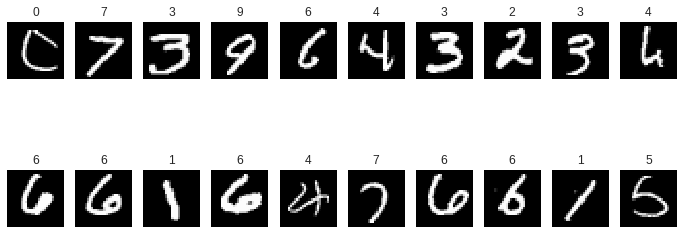

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, lables = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(12,5))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(str(lables[idx].item()))

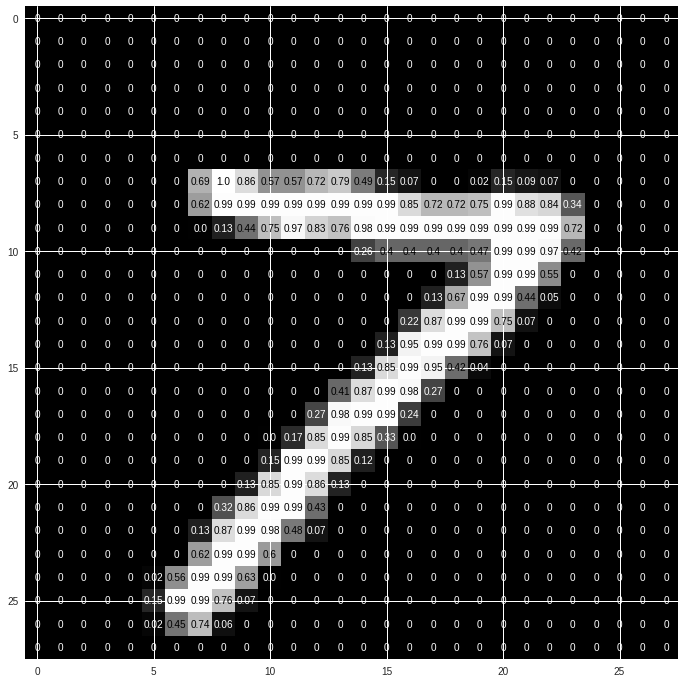

In [0]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

**Bidirectional recurrent neural network (many-to-one)**

In [0]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, num_classes, drop_prop=0.3):
        
        super(BiRNN, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size1, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prop)
        self.fc1 = nn.Linear(hidden_size1*2, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size1).to(device) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size1).to(device)
        
        # Get the outputs and the new hidden state from the lstm
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        #pass through a dropout layer
        out = self.dropout(out)
        
        # put x through the fully-connected layer
        out = self.fc1(out[:, -1, :])
        out2 = self.fc2(out)
        
        return out2

model = BiRNN(input_size, hidden_size1, hidden_size2, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    


In [0]:
# Train the model
total_step = len(train_loader)
model.train()

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))




Epoch [1/3], Step [100/1200], Loss: 1.0519
Epoch [1/3], Step [200/1200], Loss: 0.6704
Epoch [1/3], Step [300/1200], Loss: 0.7762
Epoch [1/3], Step [400/1200], Loss: 0.5680
Epoch [1/3], Step [500/1200], Loss: 0.1418
Epoch [1/3], Step [600/1200], Loss: 0.1700
Epoch [1/3], Step [700/1200], Loss: 0.2440
Epoch [1/3], Step [800/1200], Loss: 0.4138
Epoch [1/3], Step [900/1200], Loss: 0.1891
Epoch [1/3], Step [1000/1200], Loss: 0.0934
Epoch [1/3], Step [1100/1200], Loss: 0.2713
Epoch [1/3], Step [1200/1200], Loss: 0.1208
Epoch [2/3], Step [100/1200], Loss: 0.1276
Epoch [2/3], Step [200/1200], Loss: 0.1100
Epoch [2/3], Step [300/1200], Loss: 0.1068
Epoch [2/3], Step [400/1200], Loss: 0.1278
Epoch [2/3], Step [500/1200], Loss: 0.1789
Epoch [2/3], Step [600/1200], Loss: 0.1250
Epoch [2/3], Step [700/1200], Loss: 0.1677
Epoch [2/3], Step [800/1200], Loss: 0.0226
Epoch [2/3], Step [900/1200], Loss: 0.1662
Epoch [2/3], Step [1000/1200], Loss: 0.1608
Epoch [2/3], Step [1100/1200], Loss: 0.0221
Epoch 

In [0]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 97.5 %


In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for images, target in test_loader:
  
  images = images.reshape(-1, sequence_length, input_size).to(device)
  labels = labels.to(device)
  output = model(images)

  loss = criterion(output, target)
  test_loss += loss.item()*images.size(0)
  
  _, pred = torch.max(output, 1)
  correct = np.squeeze(pred.eq(target.data.view_as(pred)))
  
  for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of images of label  %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): {}%'  .format(
    100. * np.sum(class_correct) / np.sum(class_total)),"(", np.sum(class_correct),"/", np.sum(class_total),")")

Test Loss: 0.083681

Test Accuracy of images of label      0: 96% (949/980)
Test Accuracy of images of label      1: 99% (1126/1135)
Test Accuracy of images of label      2: 99% (1025/1032)
Test Accuracy of images of label      3: 97% (986/1010)
Test Accuracy of images of label      4: 99% (973/982)
Test Accuracy of images of label      5: 95% (853/892)
Test Accuracy of images of label      6: 98% (944/958)
Test Accuracy of images of label      7: 97% (1000/1028)
Test Accuracy of images of label      8: 97% (947/974)
Test Accuracy of images of label      9: 93% (947/1009)

Test Accuracy (Overall): 97.5% ( 9750.0 / 10000.0 )
